In [2]:
# import basic modules
import sys
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
from copy import deepcopy

# import custom modules
root_dir   = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root_dir, 'code'))
from model_src import fwrf_fit, fwrf_predict
from model_fitting import initialize_fitting
from utils import numpy_utility

In [3]:
subject=1
roi=None

ridge=1

shuffle_images=False
random_images=False
random_voxel_data=False

zscore_features=True
nonlin_fn=False
padding_mode='circular'

n_ori=8
n_sf=4
up_to_sess=1
debug=True

fitting_type='simple_complex'
include_crosscorrs=True
include_autocorrs=False


In [5]:
device = initialize_fitting.init_cuda()
nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()

if ridge==True:       
    # ridge regression, testing several positive lambda values (default)
    model_name = 'texture_ridge_%dori_%dsf'%(n_ori, n_sf)
else:        
    # fixing lambda at zero, so it turns into ordinary least squares
    model_name = 'texture_OLS_%dori_%dsf'%(n_ori, n_sf)

if include_autocorrs==False:
    print('Skipping autocorrs\n')
    model_name = model_name+'_no_autocorrelations'
else:
    print('Will compute autocorrs\n')

if include_crosscorrs==False:
    print('Skipping crosscorrs\n')
    model_name = model_name+'_no_crosscorrelations'
else:
    print('Will compute crosscorrs\n')   

output_dir, fn2save = initialize_fitting.get_save_path(root_dir, subject, model_name, shuffle_images, random_images, random_voxel_data, debug)

# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = initialize_fitting.get_voxel_info(mask_root, beta_root, subject, roi)

# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_single_trial_data, val_voxel_single_trial_data, \
    n_voxels, n_trials_val, image_order = initialize_fitting.get_data_splits(nsd_root, beta_root, stim_root, subject, voxel_mask, up_to_sess, 
                                                                             shuffle_images=shuffle_images, random_images=random_images, random_voxel_data=random_voxel_data)

# Set up the filters
_gaborizer_complex, _gaborizer_simple, _fmaps_fn_complex, _fmaps_fn_simple = initialize_fitting.get_feature_map_simple_complex_fn(n_ori, n_sf, padding_mode=padding_mode, device=device, nonlin_fn=nonlin_fn)

# Params for the spatial aspect of the model (possible pRFs)
#     aperture_rf_range=0.8 # using smaller range here because not sure what to do with RFs at edges...
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32
Skipping autocorrs

Will compute crosscorrs

Time Stamp: Jul-21-2021_0202

Will save final output file to /user_data/mmhender/model_fits/S01/texture_ridge_8ori_4sf_no_autocorrelations/Jul-21-2021_0202_DEBUG/

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1

In [6]:
images =trn_stim_data
sample_batch_size=10
n_features_complex, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_complex, images[0:sample_batch_size], device)

In [7]:
print(fmaps_rez)

[13, 37, 104, 298]


In [8]:
print(np.unique(models[:,2]))

[0.04       0.05557982 0.07722791 0.10730783 0.14910375 0.207179
 0.28787428 0.40000001]


In [9]:
print(np.unique(models[:,0]))

[-0.55       -0.49210526 -0.47142857 -0.44       -0.43421053 -0.39285714
 -0.37631579 -0.33       -0.31842105 -0.31428571 -0.26052632 -0.23571429
 -0.22       -0.20263158 -0.18333333 -0.15714286 -0.14473684 -0.11
 -0.08684211 -0.07857143 -0.02894737  0.          0.02894737  0.07857143
  0.08684211  0.11        0.14473684  0.15714286  0.18333333  0.20263158
  0.22        0.23571429  0.26052632  0.31428571  0.31842105  0.33
  0.37631579  0.39285714  0.43421053  0.44        0.47142857  0.49210526
  0.55      ]


3
final bbox will be:
[3, 10, 3, 10]
[3, 10, 3, 10]


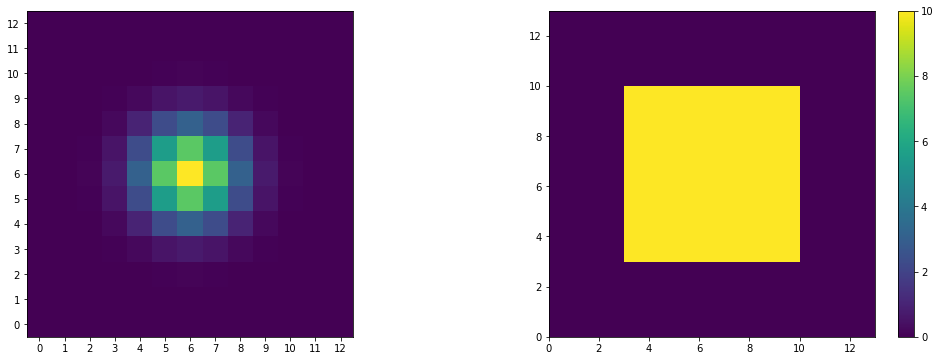

In [72]:
ff=0

# prf_params = [-0.55, -0.55, 0.04]
# prf_params = [-0.55, 0.55, 0.04]
# prf_params = [0.55, -0.55, 0.00001]
# prf_params = [0.4, 0.2, 0.04]
# prf_params = [0.55, -0.12, 0.01]

prf_params = [0,0,0.1]

# prf_params = [5/13/2+0.01, 0.02, 0.04]
# prf_params = [0.5, 0.5, 0.04]
# prf_params = [-0.3, 0.3, 0.1]
# prf_params = [-0.25, -0.25, 0.04]
# prf_params = [-0.5,0,0.001]



x,y,sigma = prf_params

# Scale specific things - get the prf at this resolution of interest
n_pix = fmaps_rez[ff]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
spatial_weights = g[2][0]
n_prf_sd_out=2
patch_bbox = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, min_pix=None, verbose=True, force_square=True)
print(patch_bbox)
[xmin, xmax, ymin, ymax] = patch_bbox



plt.figure(figsize=(18,6));
plt.subplot(1,2,1)
plt.pcolormesh(spatial_weights)
plt.axis('square')
plt.xticks(np.arange(0,n_pix)+0.5,np.arange(0,n_pix))
plt.yticks(np.arange(0,n_pix)+0.5,np.arange(0,n_pix))
plt.subplot(1,2,2)
tmp = deepcopy(spatial_weights)
tmp[xmin:xmax, ymin:ymax] = 10
plt.pcolormesh(tmp)
plt.axis('square')
plt.colorbar()

In [68]:


def get_bbox_from_prf(prf_params, image_size, n_prf_sd_out=2, min_pix=None, verbose=False, force_square=False):
    """
    For a given pRF center and size, calculate the square bounding box that captures a specified number of SDs from the center (default=2 SD)
    Returns [xmin, xmax, ymin, ymax]
    Input image has to be square.
    """
    x,y,sigma = prf_params
    n_pix = image_size[0]
    assert(image_size[1]==n_pix)
    assert(sigma>0 and n_prf_sd_out>0)
    if min_pix is not None:
        assert(min_pix<=n_pix)
    else:
        min_pix=1
        
    # decide on the window to use for correlations, based on prf parameters. Patch goes # SD from the center (2 by default).
    # note this can't be < 1, even for the smallest choice of parameters (since rounding up). this way it won't be too small.
    pix_from_center = int(np.ceil(sigma*n_prf_sd_out*n_pix))   
    pix_from_center = int(np.max([pix_from_center, np.floor(min_pix/2)]))
    print(pix_from_center)
    # center goes [row ind, col ind]
    center = np.array((n_pix/2  - y*n_pix, x*n_pix + n_pix/2)) # note that the x/y dims get swapped here because of how pRF parameters are defined.

    # now defining the extent of the bbox. want to err on the side of making it too big, so taking floor/ceiling...
    xmin = int(np.floor(center[0]-pix_from_center))
    xmax = int(np.ceil(center[0]+pix_from_center))
    ymin = int(np.floor(center[1]-pix_from_center))
    ymax = int(np.ceil(center[1]+pix_from_center))

    # cropping it to within the image bounds. Can end up being a rectangle rather than square.
    [xmin, xmax, ymin, ymax] = np.maximum(np.minimum([xmin, xmax, ymin, ymax], n_pix), 0)

    # Did the crop make it smaller than it should be?
    if xmax-xmin<min_pix:
        if xmin==0:
            xmax = min_pix
        else:
            xmin = n_pix - min_pix
    if ymax-ymin<min_pix:
        if ymin==0:
            ymax = min_pix
        else:
            ymin = n_pix - min_pix
      
    # decide if we want square or are ok with a rectangle
    minside = np.min([xmax-xmin, ymax-ymin])
    maxside = np.max([xmax-xmin, ymax-ymin])
    if minside!=maxside and force_square:

        print(min_pix)
        print(minside)
        if min_pix is None or minside>=min_pix:
            # will trim the box to make it smaller but square.
            if verbose:
                print('trimming bbox to make it square')
                print('original bbox was:')
                print([xmin, xmax, ymin, ymax])

            n2trim = [int(np.floor((maxside-minside)/2)), int(np.ceil((maxside-minside)/2))]
            if np.argmin([xmax-xmin, ymax-ymin])==0:
                ymin = ymin+n2trim[0]
                ymax = ymax-n2trim[1]
            else:
                xmin = xmin+n2trim[0]
                xmax = xmax-n2trim[1]                
        else:
            # instead of trimming, we'll move the box over until it all fits.
            if verbose:
                print('moving bbox to make it square')
                print('original bbox was:')
                print([xmin, xmax, ymin, ymax])

            if np.argmin([xmax-xmin, ymax-ymin])==0:
                if xmin==0:
                    xmax = xmax+maxside-minside
                else:
                    xmin = xmin-(maxside-minside)
            else:
                if ymin==0:
                    ymax = ymax+maxside-minside                       
                else:
                    ymin = ymin-(maxside-minside)

        assert((xmax-xmin)==(ymax-ymin))
  
    if verbose:
        print('final bbox will be:')
        print([xmin, xmax, ymin, ymax])
        
    # checking to see if the patch has become just one pixel. this can happen due to the cropping.
    # if this happens, cross-correlations will give zero.
    if ((xmax-xmin)<2 or (ymax-ymin)<2):
        print('Warning: your patch only has one pixel (for n_pix: %d and prf params: [%.2f, %.2f, %.2f])\n'%(n_pix,x,y,sigma))      
        
    return [xmin, xmax, ymin, ymax]